# CAO POINTS ANALYSIS
### AUTHOR: ANTE DUJIC
<hr style="border:2px solid black"> </hr>

## INTRODUCTION
<hr style="border:2px solid gray"> </hr>

This notebook gives an overview of how to load CAO points information from the CAO website into a pandas data frame and the comparison of CAO points in 2019, 2020, and 2021.

[<center><img src="http://www.cao.ie/images/cao.png" width="100"/></center> ](http://www.cao.ie/index.php)

***
### CONTENTS

1. [WHAT IS CAO](#CAO)
2. [LOADING AND SAVING THE DATA](#DATA)
    - 2.1. [LEVEL 8 POINTS - R1 and R2](#R1R2)
        - 2.1.1. [2019, 2020, 2021 (html)](#HTML)
    - 2.2. [LEVEL 8 POINTS - EOS and MID](#EOSMID)
        - 2.2.1. [2020 (xlsx)](#XLSX)
        - 2.2.2. [2019 (pdf)](#PDF)
2. [CONCATENATING THE DATA](#CONCATENATE)

## 1. WHAT IS CAO <a id='CAO'></a>
<hr style="border:2px solid gray"> </hr>

The purpose of the Central Applications Office (CAO) is to process centrally applications for undergraduate courses in Irish Higher Education Institutions (HEIs), and to deal with them in an efficient and fair manner. [1]

Students applying for admission to third level education courses in Ireland apply to the CAO rather than to individual educational institutions such as colleges and universities. The CAO then offers places to students who meet the minimum requirements for a course for which they have applied. If for a particular course there are more qualified applicants than available places, the CAO makes offers to those applicants with the highest score in the CAO points system. If students do not accepts offers, or later decline them because they receive an offer for another course, the CAO makes further offers until all of the places have been filled or until the offer season closes. [2]

In [1]:
# HTTP request
import requests as rq

# Regular expressions
import re

# Dates and time
import datetime as dt

# Data frames
import pandas as pd

# For downloading
import urllib.request as urlrq

# PDF
import camelot

# To use .unescape
import html

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## 2. LEVEL 8 - ROUND 1 and ROUND 2
<hr style="border:2px solid gray"> </hr>

The data for Round 1 and Round 2 for the three given years (2019., 2020., 2021.) has been pulled from the CAO website. As mentioned in the README, CAO practice is to first upload the data with only Round 1 and Round 2 points and then overwrite that data with EOS and MID points after the academic year starts. To obtain the Round 1 and Round 2 data for the 2019. and 2020. I have used [The Internet Archive](https://web.archive.org/). This didn't only allow me access to the archived version of the website but also gave me the same format and the structure of the data for all the years.


2019: https://web.archive.org/web/20191019135815/http://www2.cao.ie:80/points/l8.php <br>
2020: https://web.archive.org/web/20201108133105/http://www2.cao.ie/points/l8.php <br>
2021: http://www2.cao.ie/points/l8.php

### THE WEBSITE STRUCTURE

The data on the CAO website has the following structure:
- Title
- Information on how to read the data
- List of colleges
- Course Level Title
- Points table
    - Course code
    - Course title
    - Round 1 points
    - Round 2 points

The data of interest is contained under the table section of the website. It is explained below how the data was scrapped, cleaned and saved for the later analysis. There are a few main steps taken:
1. Save the original data
2. Read the data and filter out only the relevant data
3. Save the cleaned data as csv file

### SCRAPPING AND CLEANING THE DATA

Current data and time are used for the filenames that will get created to save the original data and the cleaned data. I've used the date and time for easier access and organization of the data, but also to avoid the overwriting of the data files.

In [2]:
# Current date and time
now = dt.datetime.now()
# Format as a string
nowstr = (now.strftime("%Y%m%d_%H%M%S"))

To filter out only relevant data from the website I've used the below regular expression. Regular expression  is a sequence of characters that specifies a search pattern. Usually such patterns are used by string-searching algorithms for "find" or "find and replace" operations on strings, or for input validation. [4] The set regular expression filters out only the lines starting with the course code (e.g. AL801).

In [3]:
# Regular expression
re_course = re.compile(r"([A-Z]{2}[0-9]{3})(.*)")

In [4]:
# Defining a dictionary
years_dict = {
    "2019": [("data/cao2019" +  nowstr), "https://web.archive.org/web/20191019135815/http://www2.cao.ie:80/points/l8.php"],
    "2020": [("data/cao2020" +  nowstr), "https://web.archive.org/web/20201108133105/http://www2.cao.ie/points/l8.php"],
    "2021": [("data/cao2021" +  nowstr), "http://www2.cao.ie/points/l8.php"]
}

In [5]:
# Loop through the (dict) years
for year, content in years_dict.items():
    # Fetch the CAO points URL
    rq.get (content[1])
    resp = rq.get (content[1])
    # The server uses the wrong encoding
        # Change to "cp1252"
    resp.encoding = "cp1252"
    # Check if OK:
        #Response [200] means OK
    print (year,resp)
    
    # Save the original html file
    with open(content[0] + ".html", "w") as f:
        f.write(resp.text)
        # Keep track of how many courses we process
    
    no_lines = 0
    # Iterating through the lines
    resp.iter_lines()
    resps = resp.iter_lines()
    
    # Open the csv file for writing.
    with open(content[0] + ".csv", "w") as f:
        # Write a header row.
        f.write(','.join(["CODE", "TITLE", "R1_POINTS", "R2_POINTS"]) + "\n")
        # Loop through lines of the response.
        for line in resps:
            # Decode the line, using the wrong encoding
            dline = line.decode("cp1252")
            # Converting &amp; to &
            dline = html.unescape(dline)
            # Match only the lines representing courses
            if re_course.fullmatch(dline):
                # Add one to the lines counter
                no_lines = no_lines + 1
                # The course code
                course_code = dline[:5]
                # The course title
                course_title = dline[7:57]
                # Round one points
                course_points = re.split(' +', dline[60:])
                if len(course_points) != 2:
                    course_points = course_points[:2]
                # Join the fields using a comma
                linesplit = [course_code, course_title, course_points[0], course_points[1]]
                # Rejoin the substrings with commas in between
                f.write(",".join(linesplit) + "\n")   
    # Print the total number of processed lines
    print("Total number of lines in CAO", year, "database is", no_lines)

2019 <Response [200]>
Total number of lines in CAO 2019 database is 930
2020 <Response [200]>
Total number of lines in CAO 2020 database is 961
2021 <Response [200]>
Total number of lines in CAO 2021 database is 949


## 2. LEVEL 8 - EOS and MID
<hr style="border:2px solid gray"> </hr>

Overview

#### 2.2.1. 2020 (xlsx) <a id='XLSX'></a>

In [6]:
# Create a file path for the original data
path = ("data/cao2020_eos" +  nowstr + ".xlsx")

In [7]:
# Copying network xlsx file
urlrq.urlretrieve('http://www2.cao.ie/points/CAOPointsCharts2020.xlsx', path)

('data/cao2020_eos20211205_150409.xlsx',
 <http.client.HTTPMessage at 0x1271ca2a160>)

In [8]:
# Download and parse the excel spreadsheet
df2020_eos = pd.read_excel("http://www2.cao.ie/points/CAOPointsCharts2020.xlsx", skiprows = 10)

In [9]:
# Filter out only level 8 courses
df2020_eos = df2020_eos.loc[df2020_eos["LEVEL"] == 8]
# Remove last 12 columns
df2020_eos = df2020_eos.iloc[: , :-12]
# Save pandas data frame to disk
df2020_eos.to_csv(("data/cao2020_eos" +  nowstr + ".csv"))
#df2020_eos

***

#### 2019 (pdf) <a id='PDF'></a>

In [10]:
# Creating a file path for the original data
path2019pdf = 'data/cao2019_eos' + nowstr + '.pdf'

In [11]:
# Fetch the CAO points URL
resp_pdf = rq.get("http://www2.cao.ie/points/lvl8_19.pdf")
resp_pdf # <Response [200]> means OK

<Response [200]>

In [12]:
# Save the original file
with open(path2019pdf, 'wb') as f:
    f.write(resp_pdf.content)

In [13]:
# Read the pdf file
tables = camelot.read_pdf(path2019pdf, pages = "all", flavor = "lattice")

In [14]:
# Check the total number of tables read
print ("Tables:", tables.n)

Tables: 18


In [15]:
# Create empty list
table_total = []
# Loop through all 18 tables
for x in range (0,18):
    df = tables[x].df
    # Append all 18 tables to table_total
    table_total.append(df)

# Concatenate all tables  
table = pd.concat(table_total)
# Remove old column names
table = table.iloc[1: , :]
# Name the columns
table.columns = ["CODE","TITLE", "EOS_2019", "MID_2019"]
# Sort table by "CODE" column
table.sort_values("CODE", inplace = True)
# Remove first 35 rows (name of the college)
table = table.iloc[35: , :]
# Save .csv file
table.to_csv("data/cao2019_eos" +  nowstr + ".csv", index = False)
#table

## 3. CONCATENATING THE DATA <a id='CONCATENATE'></a>
<hr style="border:2px solid gray"> </hr>

In [16]:
# Defining a dictionary
df_dict = {
    "2019": [("data/cao2019" +  nowstr)],
    "2019_eos": [("data/cao2019_eos" +  nowstr)],
    "2020": [("data/cao2020" +  nowstr)],
    "2020_eos": [("data/cao2020_eos" +  nowstr)],
    "2021": [("data/cao2021" +  nowstr)]
}

In [17]:
# Creating an empty list for adding dataframes
dataframe = []
# Loop - reading the csv files and appending to list
for year, path in df_dict.items():
    data = pd.read_csv ((path[0] + ".csv"), encoding='cp1252')
    dataframe.append (data)
# Conecating all dataframes into one
allcourses = pd.concat (dataframe)
# Filering out columns
allcourses = allcourses [["CODE", "TITLE"]]
# Remove duplicates created by conecating
allcourses.drop_duplicates(subset=["CODE"], inplace=True, ignore_index=False)
# Sort the table by "CODE" column
allcourses.sort_values("CODE", inplace = True)
#allcourses

In [18]:
#2019 df
dataframe[0].columns = ["CODE","TITLE", "R1_POINTS_2019", "R2_POINTS_2019"]
#2019_eos is #dataframe[1]
#2020 df
dataframe[2].columns = ["CODE","TITLE", "R1_POINTS_2020", "R2_POINTS_2020"]
#2020_eos df
dataframe[3] = dataframe[3][["COURSE CODE2","EOS", "EOS Mid-point"]]
dataframe[3].columns = ["CODE","EOS_2020", "MID_2020"]
#2021 df
dataframe[4].columns = ["CODE","TITLE", "R1_POINTS_2021", "R2_POINTS_2021"]

In [19]:
# Loop - set "CODE" column as index for all df
for i in dataframe:
    i.set_index("CODE", inplace=True)

In [20]:
allcourses.set_index("CODE", inplace=True)
allcourses = allcourses.join(dataframe[0][["R1_POINTS_2019", "R2_POINTS_2019"]])
#allcourses

In [21]:
allcourses = allcourses.join(dataframe[1][["EOS_2019", "MID_2019"]])
#allcourses

In [22]:
allcourses = allcourses.join(dataframe[2][["R1_POINTS_2020", "R2_POINTS_2020"]])
#allcourses

In [23]:
allcourses = allcourses.join(dataframe[3][["EOS_2020", "MID_2020"]])
#allcourses

In [24]:
allcourses = allcourses.join(dataframe[4][["R1_POINTS_2021", "R2_POINTS_2021"]])
#allcourses

In [25]:
#allcourses.sort_values("CODE", inplace = True)
allcourses.to_csv ("data/Final_table.csv")

allcourses


,TITLE,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
CODE,,,,,,,,,,,
AC120,International Business ...,234,234,234,269.0,209,NaN,209,280,294,294
AC137,Liberal Arts ...,275,252,252,275.0,252,NaN,252,270,271,270
AD101,First Year Art & Design (Common Entry) ...,#+Matric,NaN,# +matric 550,NaN,#+matric,NaN,#+matric,#+matric,#554,NaN
AD102,Graphic Design and Moving Image Design ...,#+Matric,NaN,# +matric 635,NaN,#+matric,NaN,#+matric,#+matric,#538,NaN
AD103,Textile & Surface Design and Jewellery & Objec...,#+Matric,NaN,# +matric 545,NaN,#+matric,NaN,#+matric,#+matric,#505,NaN
...,...,...,...,...,...,...,...,...,...,...,...
WD212,Recreation and Sport Management ...,274,NaN,274,311.0,270,NaN,270,349,262,NaN
WD230,Mechanical and Manufacturing Engineering ...,273,NaN,273,348.0,253,NaN,253,369,230,230
WD231,Early Childhood Care and Education ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266,NaN


## TESTING

In [26]:
df = pd.read_csv ("data/Final_table.csv", index_col = ["CODE", "TITLE"])
df

,,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
CODE,TITLE,,,,,,,,,,
AC120,International Business,234,234,234,269.0,209,NaN,209,280,294,294
AC137,Liberal Arts,275,252,252,275.0,252,NaN,252,270,271,270
AD101,First Year Art & Design (Common Entry),#+Matric,NaN,# +matric 550,NaN,#+matric,NaN,#+matric,#+matric,#554,NaN
AD102,Graphic Design and Moving Image Design,#+Matric,NaN,# +matric 635,NaN,#+matric,NaN,#+matric,#+matric,#538,NaN
AD103,Textile & Surface Design and Jewellery & Objects,#+Matric,NaN,# +matric 545,NaN,#+matric,NaN,#+matric,#+matric,#505,NaN
...,...,...,...,...,...,...,...,...,...,...,...
WD212,Recreation and Sport Management,274,NaN,274,311.0,270,NaN,270,349,262,NaN
WD230,Mechanical and Manufacturing Engineering,273,NaN,273,348.0,253,NaN,253,369,230,230
WD231,Early Childhood Care and Education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266,NaN


In [27]:
df.dtypes

R1_POINTS_2019     object
R2_POINTS_2019     object
EOS_2019           object
MID_2019          float64
R1_POINTS_2020     object
R2_POINTS_2020     object
EOS_2020           object
MID_2020           object
R1_POINTS_2021     object
R2_POINTS_2021     object
dtype: object

In [28]:
# Filtering out the non numeric values in df
    # Replace all strings with "none"
df_numeric = df.replace(r'\D', '', regex=True)
    # Change columns type from object to numeric
df_numeric = df.apply(pd.to_numeric, errors='coerce')
df_numeric

,,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
CODE,TITLE,,,,,,,,,,
AC120,International Business,234.0,234.0,234.0,269.0,209.0,NaN,209.0,280.0,294.0,294.0
AC137,Liberal Arts,275.0,252.0,252.0,275.0,252.0,NaN,252.0,270.0,271.0,270.0
AD101,First Year Art & Design (Common Entry),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AD102,Graphic Design and Moving Image Design,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AD103,Textile & Surface Design and Jewellery & Objects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
WD212,Recreation and Sport Management,274.0,NaN,274.0,311.0,270.0,NaN,270.0,349.0,262.0,NaN
WD230,Mechanical and Manufacturing Engineering,273.0,NaN,273.0,348.0,253.0,NaN,253.0,369.0,230.0,230.0
WD231,Early Childhood Care and Education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266.0,NaN


In [29]:
df_numeric.to_csv ("Numeric_table.csv")

In [30]:
df_numeric.dtypes

R1_POINTS_2019    float64
R2_POINTS_2019    float64
EOS_2019          float64
MID_2019          float64
R1_POINTS_2020    float64
R2_POINTS_2020    float64
EOS_2020          float64
MID_2020          float64
R1_POINTS_2021    float64
R2_POINTS_2021    float64
dtype: object

In [31]:
# 2019
r1_2019 = df_numeric ["R1_POINTS_2019"]
r2_2019 = df_numeric ["R2_POINTS_2019"]
eos_2019 = df_numeric ["EOS_2019"]
mid_2019 = df_numeric ["MID_2019"]
# 2020
r1_2020 = df_numeric ["R1_POINTS_2020"]
r2_2020 = df_numeric ["R2_POINTS_2020"]
eos_2020 = df_numeric ["EOS_2020"]
mid_2020 = df_numeric ["MID_2020"]
# 2021
r1_2021 = df_numeric ["R1_POINTS_2021"]
r2_2021 = df_numeric ["R2_POINTS_2021"]

In [32]:
r1_2019

CODE   TITLE                                             
AC120  International Business                                234.0
AC137  Liberal Arts                                          275.0
AD101  First Year Art & Design (Common Entry)                  NaN
AD102  Graphic Design and Moving Image Design                  NaN
AD103  Textile & Surface Design and Jewellery & Objects        NaN
                                                             ...  
WD212  Recreation and Sport Management                       274.0
WD230  Mechanical and Manufacturing Engineering              273.0
WD231  Early Childhood Care and Education                      NaN
WD232  Business Information Systems                            NaN
NaN    NaN                                                     NaN
Name: R1_POINTS_2019, Length: 1147, dtype: float64

In [33]:
df_numeric.describe()

,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
count,790.000000,161.000000,792.000000,906.000000,816.000000,162.000000,927.000000,926.000000,778.000000,194.000000
mean,357.605063,344.763975,351.459596,424.698675,367.365196,356.067901,387.396980,443.506479,380.690231,368.592784
std,88.934011,104.528018,88.269647,132.632707,96.647961,108.215229,129.961258,131.347780,101.273464,113.695412
min,195.000000,146.000000,168.000000,57.000000,184.000000,184.000000,55.000000,57.000000,201.000000,176.000000
25%,288.000000,251.000000,285.750000,339.000000,294.000000,253.000000,298.000000,359.000000,300.000000,264.000000
50%,338.000000,325.000000,330.000000,392.000000,342.000000,336.500000,361.000000,418.000000,367.000000,357.500000
75%,420.000000,435.000000,410.250000,476.000000,440.000000,450.250000,465.000000,498.000000,465.000000,460.750000
max,601.000000,565.000000,601.000000,1073.000000,613.000000,554.000000,1088.000000,1088.000000,613.000000,625.000000


In [34]:
df_points = df_numeric [["R1_POINTS_2019", "R1_POINTS_2020", "R1_POINTS_2021",
                        "R2_POINTS_2019", "R2_POINTS_2020", "R2_POINTS_2021"]]
df_points.corr()

,R1_POINTS_2019,R1_POINTS_2020,R1_POINTS_2021,R2_POINTS_2019,R2_POINTS_2020,R2_POINTS_2021
R1_POINTS_2019,1.000000,0.963784,0.946419,0.978780,0.970896,0.956391
R1_POINTS_2020,0.963784,1.000000,0.946773,0.952368,0.992797,0.924323
R1_POINTS_2021,0.946419,0.946773,1.000000,0.946896,0.954453,0.988723
R2_POINTS_2019,0.978780,0.952368,0.946896,1.000000,0.965924,0.947547
R2_POINTS_2020,0.970896,0.992797,0.954453,0.965924,1.000000,0.947369
R2_POINTS_2021,0.956391,0.924323,0.988723,0.947547,0.947369,1.000000


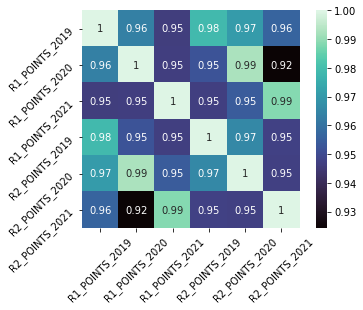

In [35]:
sns.heatmap (data = df_points.corr(), square = True, annot = True, cmap = "mako")
plt.xticks (rotation = 45)
plt.yticks (rotation = 45)
plt.show()

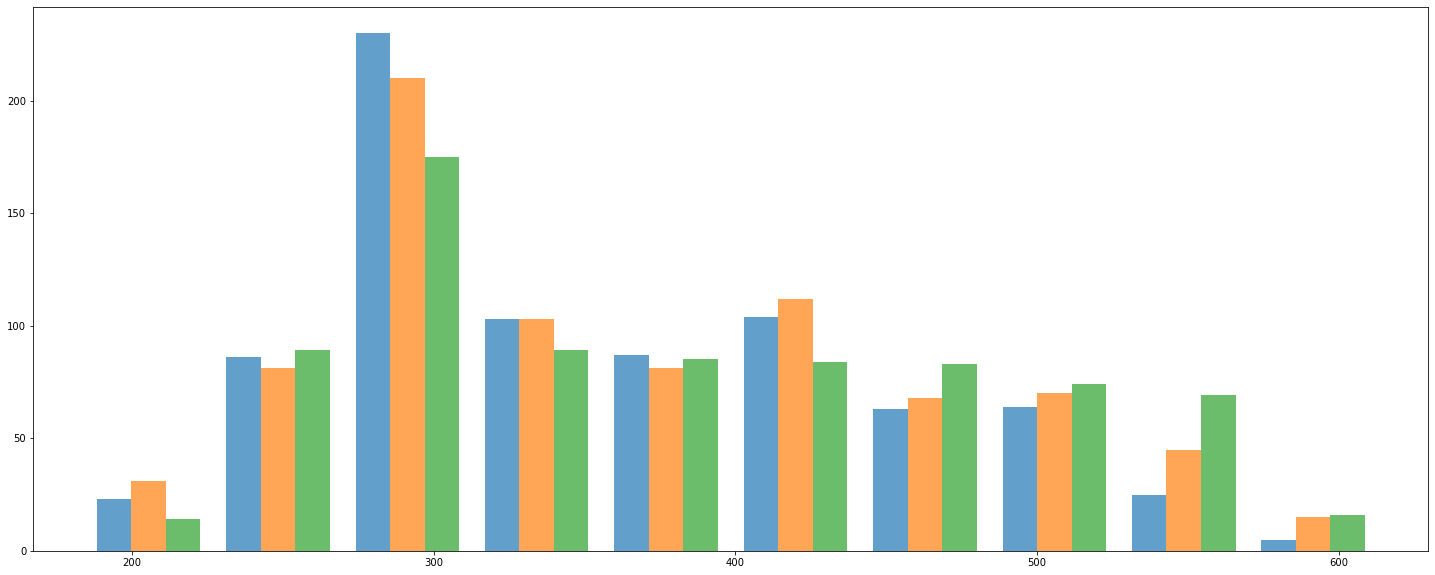

In [36]:
import numpy as np
plt.rcParams['figure.figsize'] = [25, 10]
plt.xticks (ticks = (100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100))
plt.hist ([r1_2019, r1_2020, r1_2021], alpha = 0.7)
plt.show()

In [37]:
new = pd.read_csv ("Numeric_table.csv")
new

,CODE,TITLE,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
0,AC120,International Business ...,234.0,234.0,234.0,269.0,209.0,NaN,209.0,280.0,294.0,294.0
1,AC137,Liberal Arts ...,275.0,252.0,252.0,275.0,252.0,NaN,252.0,270.0,271.0,270.0
2,AD101,First Year Art & Design (Common Entry) ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AD102,Graphic Design and Moving Image Design ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AD103,Textile & Surface Design and Jewellery & Objec...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1142,WD212,Recreation and Sport Management ...,274.0,NaN,274.0,311.0,270.0,NaN,270.0,349.0,262.0,NaN
1143,WD230,Mechanical and Manufacturing Engineering ...,273.0,NaN,273.0,348.0,253.0,NaN,253.0,369.0,230.0,230.0
1144,WD231,Early Childhood Care and Education ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266.0,NaN
1145,WD232,Business Information Systems ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.0,261.0


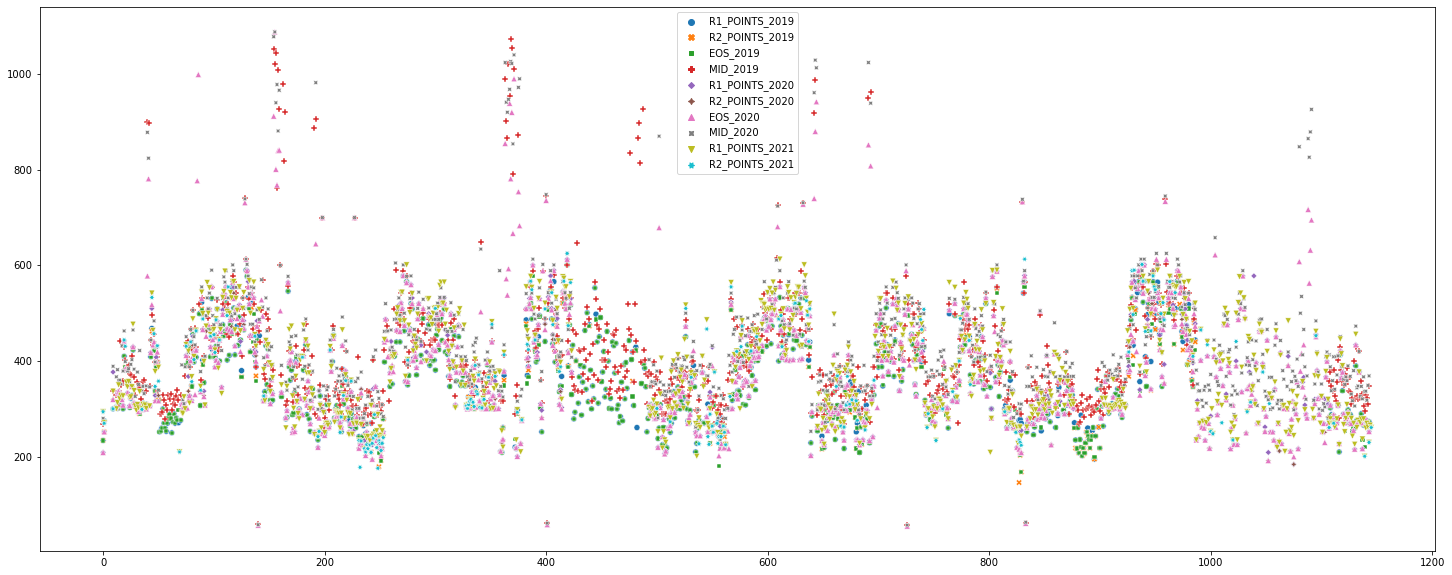

In [38]:
sns.scatterplot (data = new)
plt.show()

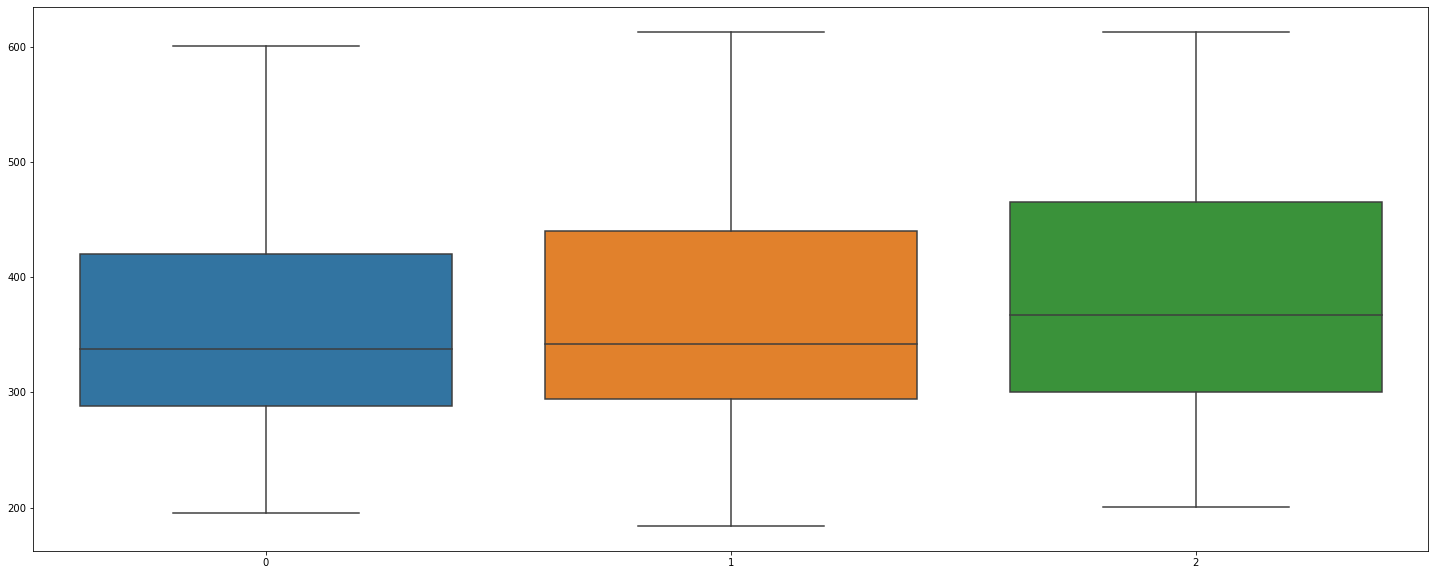

In [39]:
sns.boxplot (data = [r1_2019, r1_2020, r1_2021])
plt.show()

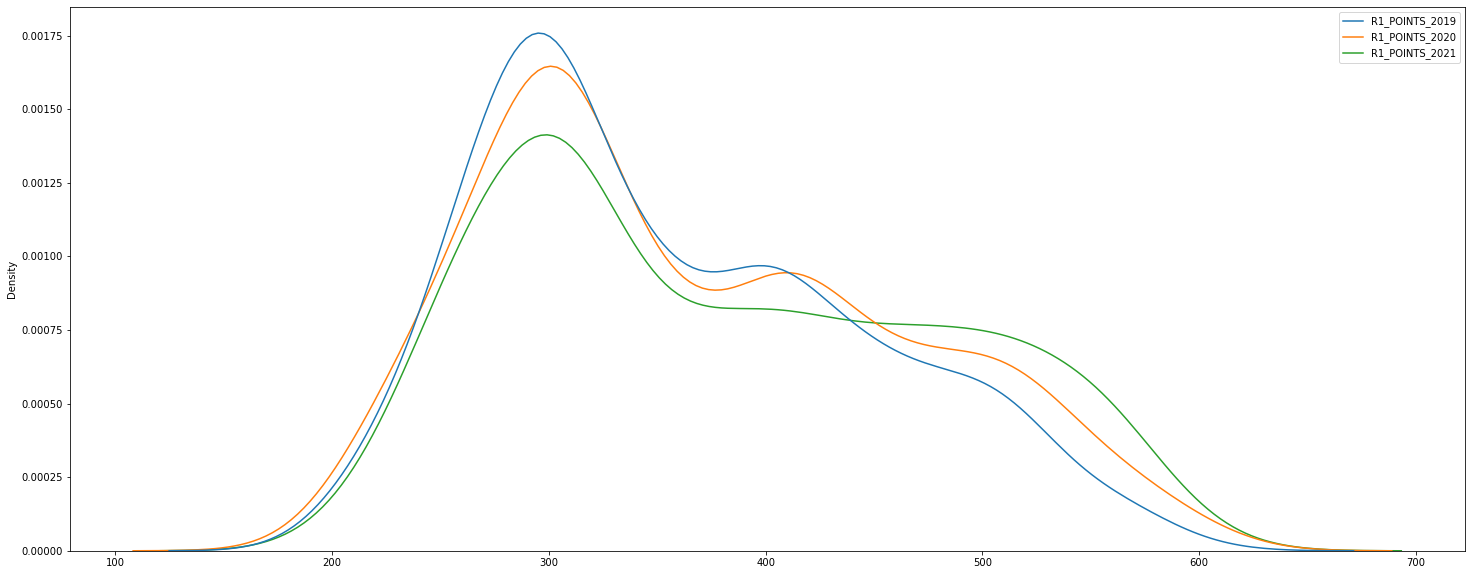

In [40]:
sns.kdeplot (data = [r1_2019, r1_2020, r1_2021])
plt.show()

### DATA COMPARISON

# CONCLUSION

***

## REFERENCES
***

- [1] http://www2.cao.ie/handbook/handbook2022/hb.pdf
- [2] https://en.wikipedia.org/wiki/Central_Applications_Office7
- [3] https://www.independent.ie/life/family/learning/understanding-your-cao-course-guide-26505318.html
- [4] https://en.wikipedia.org/wiki/Regular_expression

## TESTING

In [41]:
df_numeric.dropna(axis = 0, how = 'all', inplace = True)
df_numeric

,,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
CODE,TITLE,,,,,,,,,,
AC120,International Business,234.0,234.0,234.0,269.0,209.0,NaN,209.0,280.0,294.0,294.0
AC137,Liberal Arts,275.0,252.0,252.0,275.0,252.0,NaN,252.0,270.0,271.0,270.0
AD215,Visual Culture,300.0,NaN,300.0,338.0,377.0,320.0,320.0,389.0,337.0,300.0
AL801,Software Design with Virtual Reality and Gaming,304.0,NaN,304.0,328.0,303.0,NaN,303.0,367.0,300.0,NaN
AL802,Software Design with Cloud Computing,301.0,NaN,301.0,306.0,332.0,NaN,332.0,382.0,313.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
WD211,Creative Computing,275.0,NaN,275.0,322.0,271.0,NaN,271.0,318.0,270.0,NaN
WD212,Recreation and Sport Management,274.0,NaN,274.0,311.0,270.0,NaN,270.0,349.0,262.0,NaN
WD230,Mechanical and Manufacturing Engineering,273.0,NaN,273.0,348.0,253.0,NaN,253.0,369.0,230.0,230.0


In [42]:
a = df[df['R1_POINTS_2019'].str.contains("\*", na = False)]
a

,,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
CODE,TITLE,,,,,,,,,,
AL832,Psychiatric Nursing,387*,387,387,403.0,387*,384,384,399,440*,431
AS002,Education Home Economics and Religious Ed - with c,401*,400*,400*,433.0,441*,434*,434,466,464,452*
CK201,Commerce,465*,NaN,465*,489.0,477*,NaN,477,509,500,499*
CK710,General Nursing,444*,443*,440,466.0,454*,NaN,454,477,498*,497*
CK712,Children`s and General Nursing (Integrated),509*,499*,499,520.0,533,NaN,533,553,565,NaN
DC002,Education - Primary Teaching,462*,NaN,462*,485.0,488,NaN,488,520,518*,NaN
DC171,Applied Physics,402*,402,402,433.0,NaN,NaN,NaN,NaN,NaN,NaN
DC173,Physics with Biomedical Sciences,402*,NaN,402,458.0,NaN,NaN,NaN,NaN,NaN,NaN
DC218,Children`s and General Nursing (Integrated),473*,467,467,480.0,500,498,498,522,521*,NaN


In [43]:
a['R1_POINTS_2019'].str.split('[0-9]').str[-1]


CODE   TITLE                                             
AL832  Psychiatric Nursing                                   *
AS002  Education Home Economics and Religious Ed - with c    *
CK201  Commerce                                              *
CK710  General Nursing                                       *
CK712  Children`s and General Nursing (Integrated)           *
DC002  Education - Primary Teaching                          *
DC171  Applied Physics                                       *
DC173  Physics with Biomedical Sciences                      *
DC218  Children`s and General Nursing (Integrated)           *
DK877  Midwifery                                             *
DN230  Actuarial and Financial Studies                       *
DN401  Medicine - Graduate Entry (GAMSAT required)           *
DN650  Commerce                                              *
GY501  Medicine (five year/six year course HPAT required)    *
LM090  Physical Education with concurrent Teacher Educati   